In [2]:
import sys
sys.path.insert(0,'../')
import pandas as pd
import numpy as np
import os
import seaborn as sns
from Bio.Seq import Seq
from functions import params
from functions import data_processing as dp
from functions import basic_figures as bf
from functions import lib_table_operations as lto
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

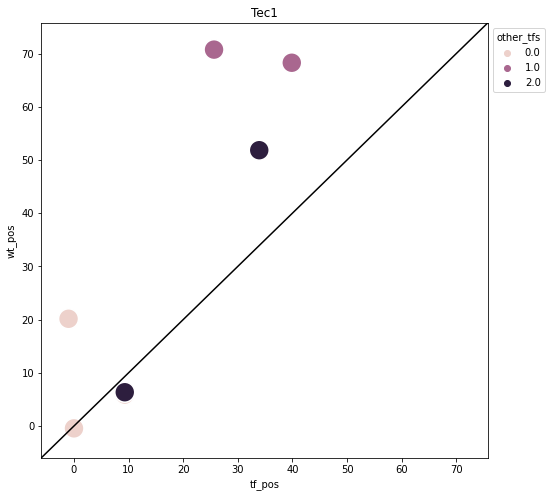

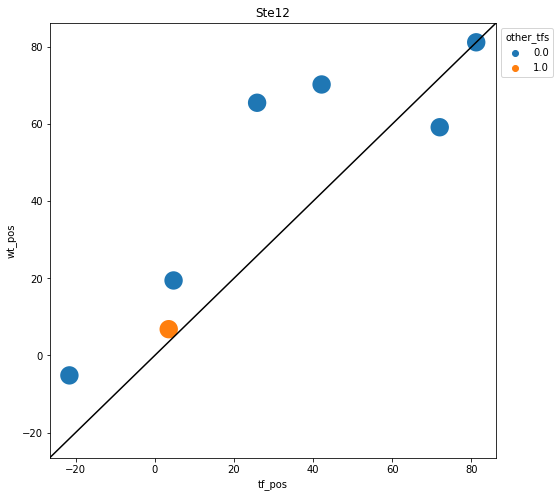

In [3]:
tp = '180'
wanted_exps = [13]
thresh = 10
tfs = ['Tec1','Ste12']
for tf in tfs:
    files = np.sort(dp.find_tf_files(tf))
    to_perc = 100
    wt_res = []
    tf_res = []
    lib_name = []
    exp_num = []
    other_tf_mot_bound = []
    for i,m_exp in enumerate(wanted_exps):
        for file in files:
            _,lib_num,exp = file.split('.')[0].split('_')
            tf_mot_pos = lto.get_tf_mot_pos(tf,lib_num)
            non_tf_mot_pos = lto.non_tf_mot_pos(tf,lib_num)
            if (len(tf_mot_pos) >= 0) & (int(exp)==m_exp): # change between == 1 to > 1 to change library type
                lib_info = dp.get_lib_info(lib_num)
                norm_df = lto.norm_res_data(tf, lib_num, exp, None, occ=True)
                wt_val,_ = lto.get_values_by_wt_pos(range(0,len(lib_info['mut_loc'])),norm_df,lib_num)
                tf_val,_ = lto.get_values_by_wt_pos(tf_mot_pos,norm_df,lib_num)
                wt_res.append(dp.mean_over_bio_reps(wt_val)[tp].values[0]*to_perc)
                tf_res.append(dp.mean_over_bio_reps(tf_val)[tp].values[0]*to_perc)
                curr_res,_ = lto.only_pos_intact_change_calc(tf,lib_num,exp,None,occ=True)
                other_tf_mot_bound.append(np.sum(curr_res.iloc[:,non_tf_mot_pos].loc[tp,:]*to_perc>thresh))
                lib_name.append(lib_info['gene']+'_'+str(lib_num))
                exp_num.append(exp)
    wn_cols = ['tf_pos','wt_pos','lib','exp','other_tfs']
    df = pd.DataFrame([tf_res,wt_res,lib_name,exp_num,other_tf_mot_bound]).T
    df.columns = wn_cols
    df = df.groupby('lib').mean()
    df['other_tfs'] = df['other_tfs'].apply(np.ceil)
    fig,ax = plt.subplots(1,1,figsize=(8,8))
    sns.scatterplot(data=df,x='tf_pos',y='wt_pos',hue='other_tfs',s=400)
    ax.set_title(tf)
    min_lim = min(df.iloc[:,:2].min()-5)
    max_lim = max(df.iloc[:,:2].max()+5)
    ax.set_xlim(min_lim, max_lim)
    ax.set_ylim(min_lim, max_lim)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.axline((0, 0), slope=1, c='k')
    plt.show()